In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel

In [2]:
train = pd.read_csv('train-space.csv')
test = pd.read_csv('test-space.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Os 4 primeiros números no Id do passageiro indicam o grupo que está viajando. Extrair esta informação pode ser útil.

In [4]:
#Utilizando str.split para separar o grupo dos passageiros
split = train['PassengerId'].str.split('_', expand = True)
train['Group'] = split[0]
split_test = test['PassengerId'].str.split('_', expand = True)
test['Group'] = split_test[0]

A cabine também está descrita na forma deck/num/side. Também pode ser útil separar estas informações. 

In [5]:
cabin = train['Cabin'].str.split('/', expand = True)
train['Deck'] = cabin[0]
train['Cabin Number'] = cabin[1]
train['Side'] = cabin[2] # P: Port or S: Starboard
cabin_test = test['Cabin'].str.split('/', expand = True)
test['Deck'] = cabin_test[0]
test['Cabin Number'] = cabin_test[1]
test['Side'] = cabin_test[2] # P: Port or S: Starboard

In [6]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,0005,F,0,P
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,0006,F,2,S
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,0006,G,0,S
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,0007,F,3,S
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,0008,B,1,P


Verificando se existem dados duplicados:

In [7]:
train[train.duplicated()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin Number,Side


In [8]:
test[test.duplicated()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,Cabin Number,Side


Verificando valores nulos:

In [9]:
print('Nulos treino:\n', train.isnull().sum(), '\n\nNulos teste:\n', test.isnull().sum())

Nulos treino:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
Deck            199
Cabin Number    199
Side            199
dtype: int64 

Nulos teste:
 PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Group             0
Deck            100
Cabin Number    100
Side            100
dtype: int64


Farei o tratamento dos dados nulos em cada atributo, começando pelos categóricos, onde substituirei os dados nulos pela moda.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   object 
 15  Deck          8494 non-null   object 
 16  Cabin Number  8494 non-null   object 
 17  Side          8494 non-null   object 
dtypes: bool(1), float64(6), obje

In [11]:
def categoricos (df, atributo):
    print('Valores:\n', df[atributo].unique(), '\n\nQuantidades:\n', df[atributo].value_counts(dropna = False))
    contagem = df[atributo].value_counts(dropna = False)
    contagem.plot.bar(color = 'blue', figsize = (10,5), title = df[atributo].name, ylabel = 'Count')

Valores:
 ['Europa' 'Earth' 'Mars' nan] 

Quantidades:
 Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: HomePlanet, dtype: int64


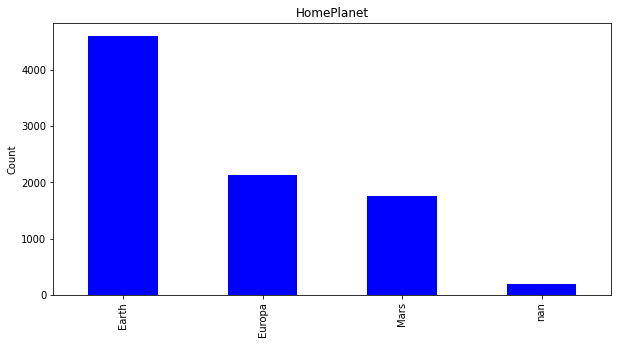

In [12]:
#HomePlanet
categoricos(train, 'HomePlanet')

Valores:
 ['Europa' 'Earth' 'Mars'] 

Quantidades:
 Earth     4803
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64


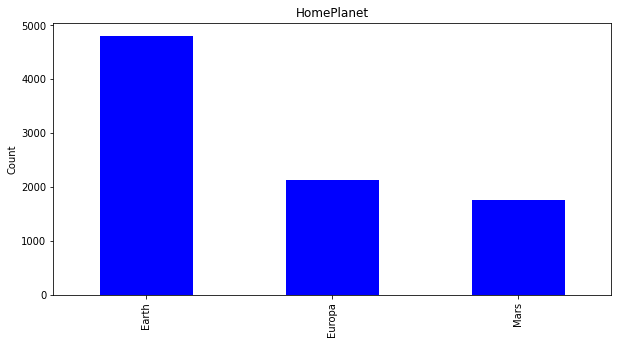

In [13]:
train['HomePlanet'].fillna('Earth', inplace = True)
test['HomePlanet'].fillna('Earth', inplace = True)
categoricos(train, 'HomePlanet')

Valores:
 [False True nan] 

Quantidades:
 False    5439
True     3037
NaN       217
Name: CryoSleep, dtype: int64


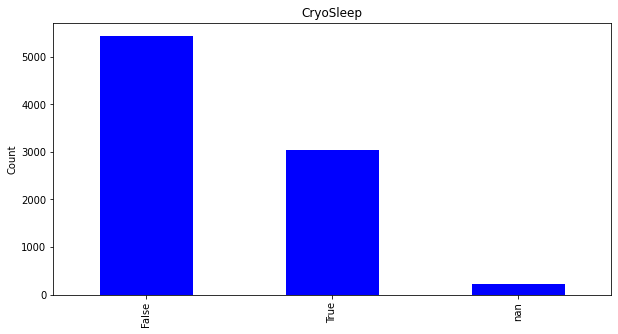

In [14]:
#CryoSleep
categoricos(train, 'CryoSleep')

Valores:
 [False  True] 

Quantidades:
 False    5656
True     3037
Name: CryoSleep, dtype: int64


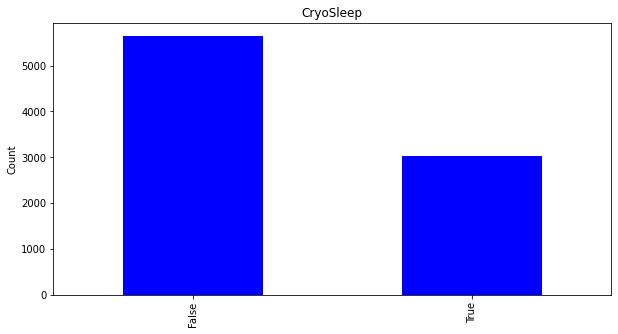

In [15]:
train['CryoSleep'].fillna(False, inplace = True)
test['CryoSleep'].fillna(False, inplace = True)
categoricos(train, 'CryoSleep')

Valores:
 ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan] 

Quantidades:
 TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: Destination, dtype: int64


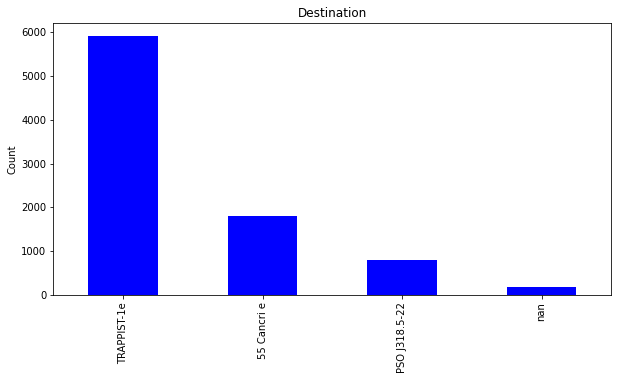

In [16]:
#Destination
categoricos(train, 'Destination')

Valores:
 ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e'] 

Quantidades:
 TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


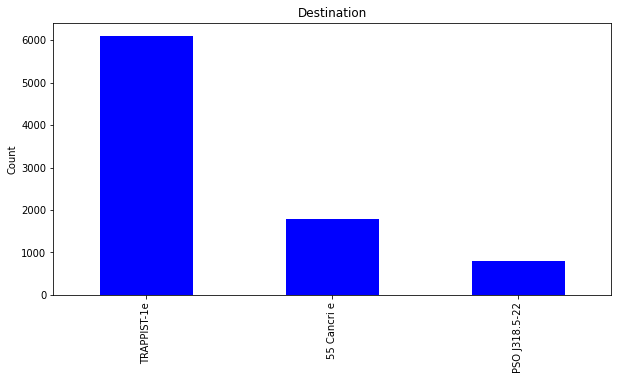

In [17]:
train['Destination'].fillna('TRAPPIST-1e', inplace = True)
test['Destination'].fillna('TRAPPIST-1e', inplace = True)
categoricos(train, 'Destination')

Valores:
 [False True nan] 

Quantidades:
 False    8291
NaN       203
True      199
Name: VIP, dtype: int64


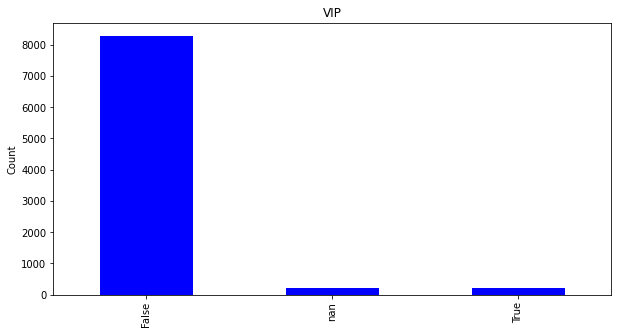

In [18]:
#VIP
categoricos(train, 'VIP')

Valores:
 [False  True] 

Quantidades:
 False    8494
True      199
Name: VIP, dtype: int64


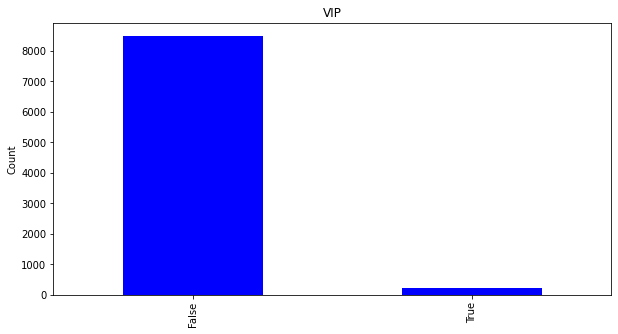

In [19]:
train['VIP'].fillna(False, inplace = True)
test['VIP'].fillna(False, inplace = True)
categoricos(train, 'VIP')

Valores:
 ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T'] 

Quantidades:
 F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: Deck, dtype: int64


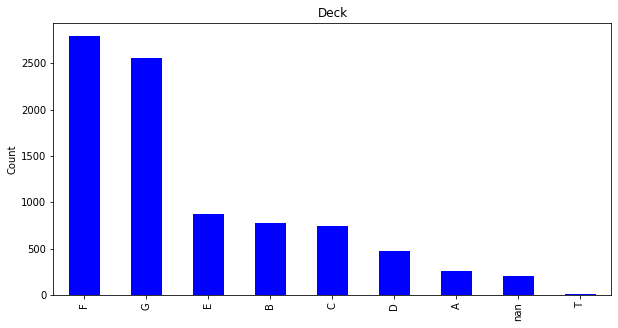

In [20]:
#Deck
categoricos(train, 'Deck')

Valores:
 ['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T'] 

Quantidades:
 F    2993
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64


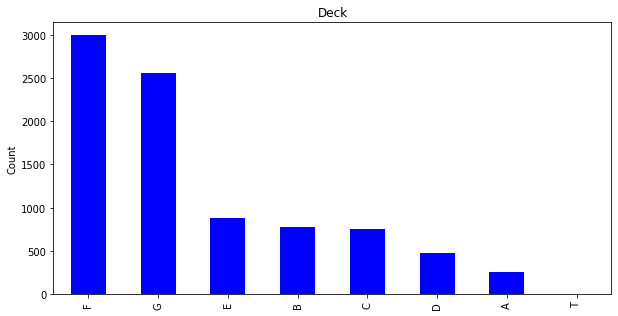

In [21]:
train['Deck'].fillna('F', inplace = True)
test['Deck'].fillna('F', inplace = True)
categoricos(train, 'Deck')

Valores:
 ['P' 'S' nan] 

Quantidades:
 S      4288
P      4206
NaN     199
Name: Side, dtype: int64


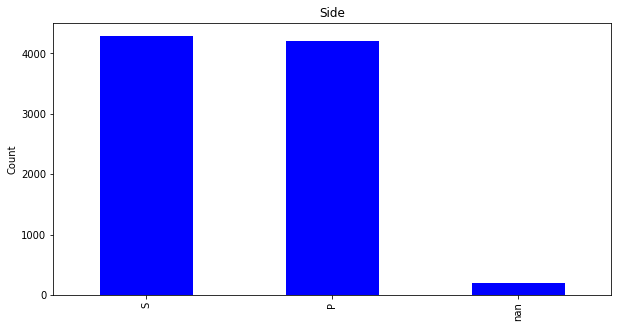

In [22]:
#Side
categoricos(train, 'Side')

Valores:
 ['P' 'S'] 

Quantidades:
 S    4487
P    4206
Name: Side, dtype: int64


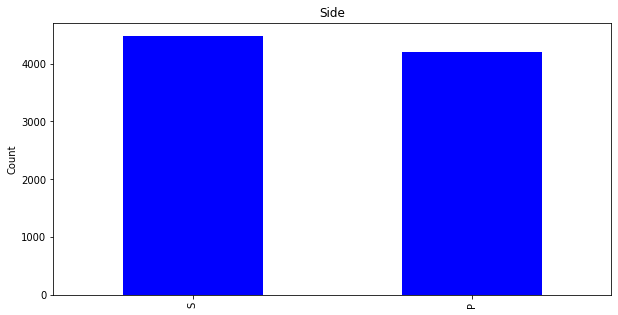

In [23]:
train['Side'].fillna('S', inplace = True)
test['Side'].fillna('S', inplace = True)
categoricos(train, 'Side')

In [24]:
train['Group'] = train['Group'].astype('int32', errors ='ignore')
test['Group'] = test['Group'].astype('int32', errors = 'ignore')

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8494 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   int32  
 15  Deck          8693 non-null   object 
 16  Cabin Number  8494 non-null   object 
 17  Side          8693 non-null   object 
dtypes: bool(3), float64(6), int3

In [26]:
print('Nulos treino:\n', train.isnull().sum(), '\n\nNulos teste:\n', test.isnull().sum())

Nulos treino:
 PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age             179
VIP               0
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
Deck              0
Cabin Number    199
Side              0
dtype: int64 

Nulos teste:
 PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           100
Destination       0
Age              91
VIP               0
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Group             0
Deck              0
Cabin Number    100
Side              0
dtype: int64


In [27]:
def numericos (df, atributo, bins):
    print(df[atributo].describe())
    fig = plt.figure(figsize = (15,5))
    fig.add_subplot(1,2,1)
    plt.hist(df[atributo], color = 'blue', bins = bins)
    plt.title('Histograma')
    plt.xlabel(df[atributo].name)
    plt.ylabel('Count')
    fig.add_subplot(1,2,2)
    plt.title('Boxplot')
    sns.boxplot(x = df[atributo])

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


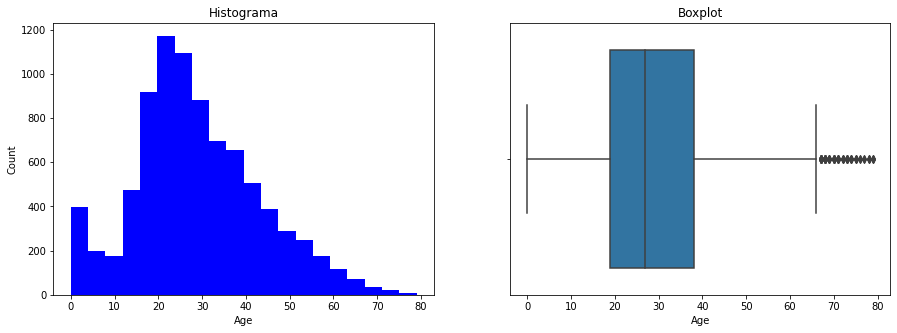

In [28]:
#Age
numericos(train, 'Age', 20)

Em Age, além de alguns dados nulos, também temos idades iguais a 0, o que não seria possível. Neste caso, farei a substituição dos dados nulos e das idades iguais a 0 pela mediana, que no caso é 27.

count    8693.000000
mean       29.343150
std        13.728128
min         1.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64


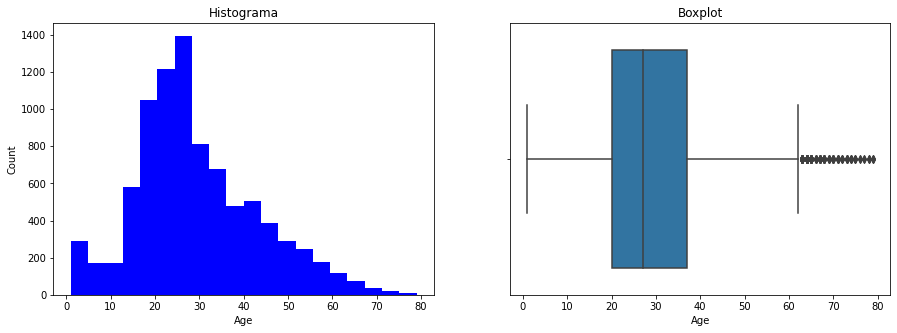

In [29]:
mediana_age = train['Age'].median()
train['Age'].fillna(mediana_age, inplace = True)
test['Age'].fillna(mediana_age, inplace = True)
train.loc[train['Age'] == 0, 'Age'] = mediana_age
test.loc[train['Age'] == 0, 'Age'] = mediana_age
numericos(train, 'Age', 20)

count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64


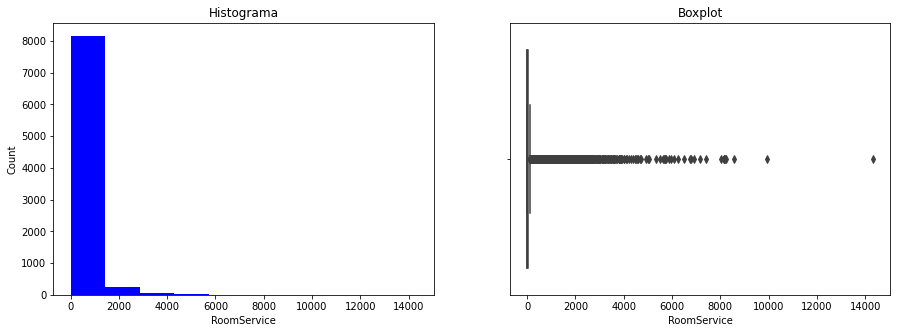

In [30]:
#RoomService
numericos(train, 'RoomService', 10)

count     8693.000000
mean       220.009318
std        660.519050
min          0.000000
25%          0.000000
50%          0.000000
75%         41.000000
max      14327.000000
Name: RoomService, dtype: float64


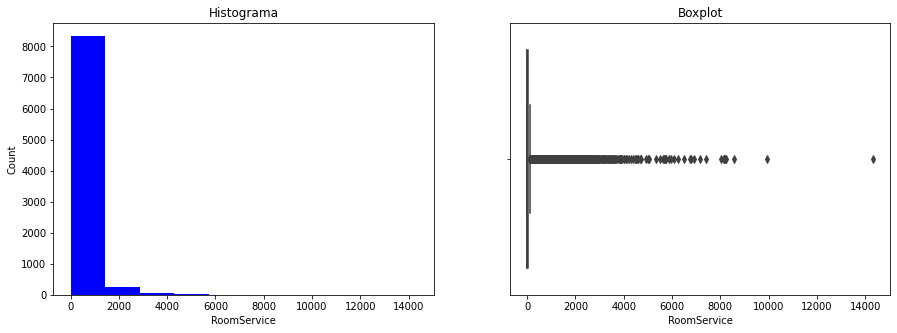

In [31]:
train['RoomService'].fillna(0, inplace = True)
test['RoomService'].fillna(0, inplace = True)
numericos(train, 'RoomService', 10)

count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64


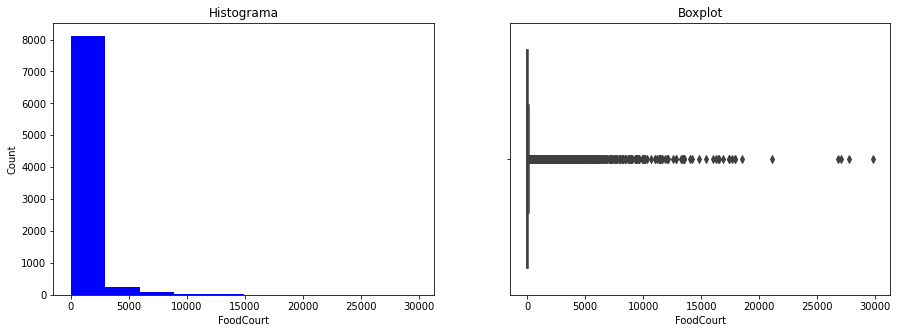

In [32]:
#FoodCourt
numericos(train, 'FoodCourt', 10) 

count     8693.000000
mean       448.434027
std       1595.790627
min          0.000000
25%          0.000000
50%          0.000000
75%         61.000000
max      29813.000000
Name: FoodCourt, dtype: float64


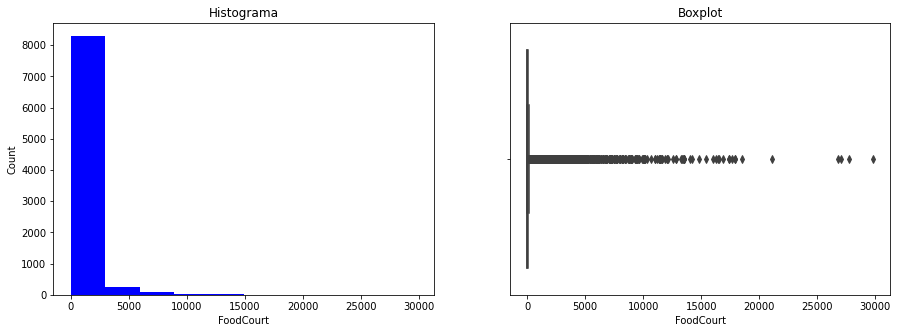

In [33]:
train['FoodCourt'].fillna(0, inplace = True)
test['FoodCourt'].fillna(0, inplace = True)
numericos(train, 'FoodCourt', 10)

count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


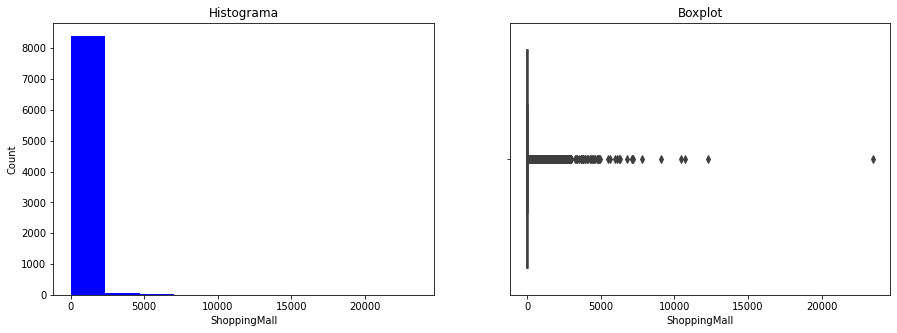

In [34]:
#ShoppingMall
numericos(train, 'ShoppingMall', 10)

count     8693.000000
mean       169.572300
std        598.007164
min          0.000000
25%          0.000000
50%          0.000000
75%         22.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


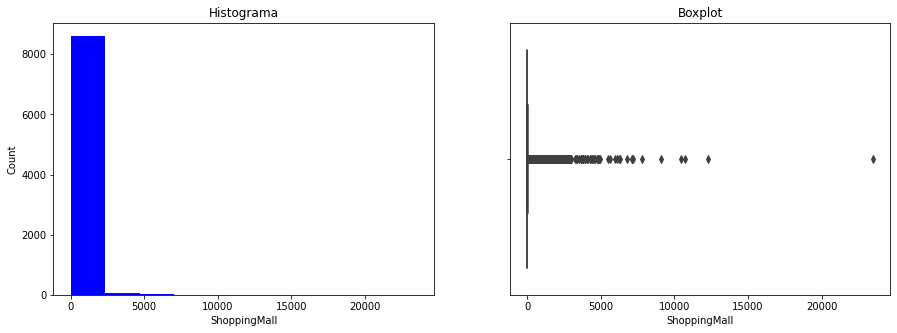

In [35]:
train['ShoppingMall'].fillna(0, inplace = True)
test['ShoppingMall'].fillna(0, inplace = True)
numericos(train, 'ShoppingMall', 10)

count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64


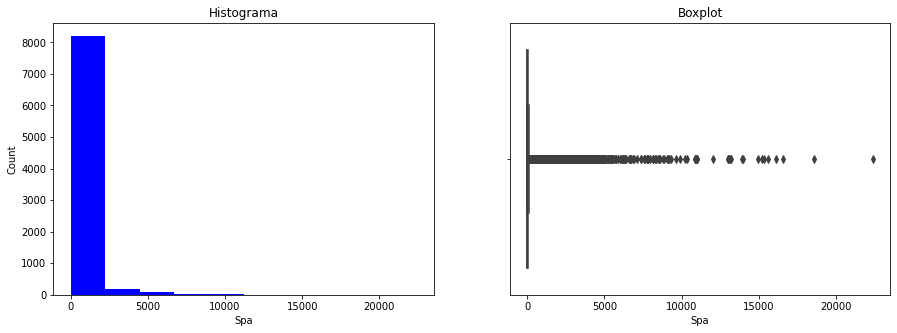

In [36]:
#Spa
numericos(train, 'Spa', 10)

count     8693.000000
mean       304.588865
std       1125.562559
min          0.000000
25%          0.000000
50%          0.000000
75%         53.000000
max      22408.000000
Name: Spa, dtype: float64


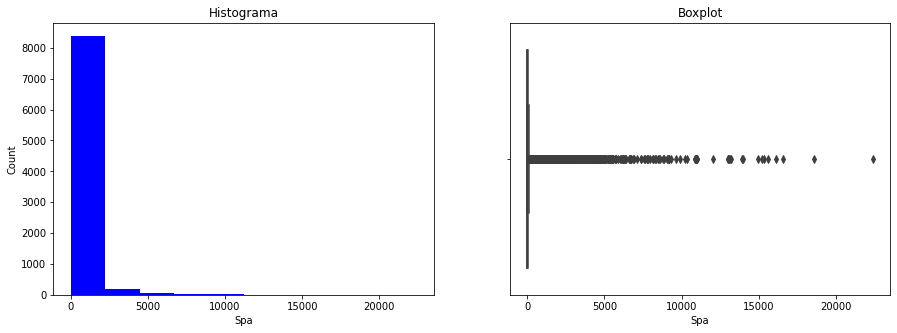

In [37]:
train['Spa'].fillna(0, inplace = True)
test['Spa'].fillna(0, inplace = True)
numericos(train, 'Spa', 10)

count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64


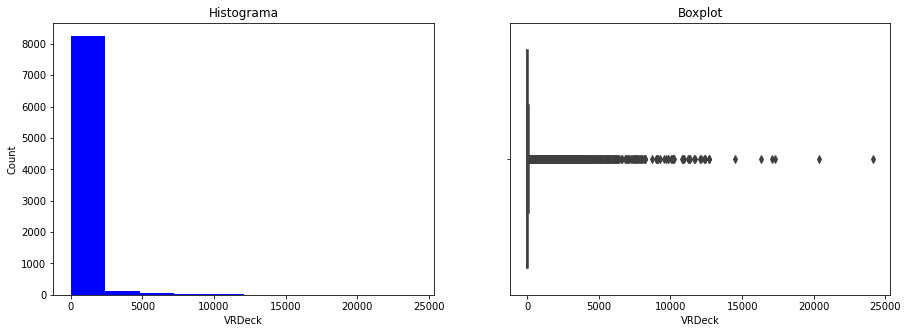

In [38]:
#VRDeck
numericos(train, 'VRDeck', 10)

count     8693.000000
mean       298.261820
std       1134.126417
min          0.000000
25%          0.000000
50%          0.000000
75%         40.000000
max      24133.000000
Name: VRDeck, dtype: float64


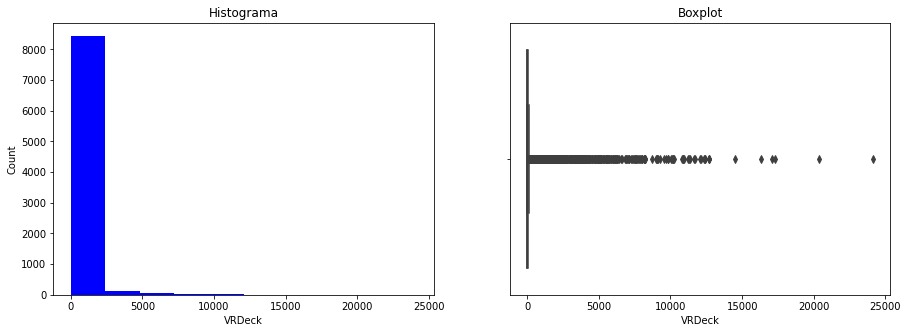

In [39]:
train['VRDeck'].fillna(0, inplace = True)
test['VRDeck'].fillna(0, inplace = True)
numericos(train, 'VRDeck', 10)

Nos atributos RoomService, FoodCourt, Spa, VRDeck e ShoppingMall, que representam os gastos dos passageiros com os luxos da nave espacial, podemos observar que a maioria dos passageiros não gastaram nada, e alguns poucos tiveram gastos mais elevados, o que pode ser notado pelos Outliers, mais visíveis no BoxPlot. Nestes casos, a mediana ficou em 0, como demonstrado no quartil 50%, e substituí os valores faltantes pela mediana.

Agora farei exclusão de algumas variáveis, que não terão contribuição com o modelo de Machine Learning.

In [40]:
train.drop(columns = ['PassengerId', 'Cabin', 'Name', 'Cabin Number'], inplace = True)
test.drop(columns = ['PassengerId', 'Cabin', 'Name', 'Cabin Number'], inplace = True)

In [41]:
print('Nulos treino:\n', train.isnull().sum(), '\n\nNulos teste:\n', test.isnull().sum())
train.info()

Nulos treino:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Group           0
Deck            0
Side            0
dtype: int64 

Nulos teste:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Group           0
Deck            0
Side            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   F

O próximo passo é deixar os valores numéricos em escala.

In [42]:
#Atributos numéricos
quantitativos = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group']

#StandardScaler
scaler = StandardScaler()

#Normalizando
atributos_escala = scaler.fit_transform(train[quantitativos])
atributos_escala_test = scaler.transform(test[quantitativos])
atributos_escala = pd.DataFrame(atributos_escala, columns = quantitativos)
atributos_escala_test = pd.DataFrame(atributos_escala_test, columns = quantitativos)

#Excluíndo as colunas sem normalização
train.drop(columns = quantitativos, inplace = True)
test.drop(columns = quantitativos, inplace = True)

#Concatenando as novas colunas normalizadas
train = pd.concat([train, atributos_escala], axis = 1)
test = pd.concat([test, atributos_escala_test], axis = 1)

#Visualizando o DataFrame com as alterações
train.head()

,HomePlanet,CryoSleep,Destination,VIP,Transported,Deck,Side,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group
0,Europa,False,TRAPPIST-1e,False,False,B,P,0.703476,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.734409
1,Earth,False,TRAPPIST-1e,False,True,F,S,-0.389234,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-1.734034
2,Europa,False,TRAPPIST-1e,True,False,A,S,2.087575,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.733660
3,Europa,False,TRAPPIST-1e,False,False,A,S,0.266392,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.733660
4,Earth,False,TRAPPIST-1e,False,True,F,S,-0.972013,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-1.733286


Agora para utilizar os atributos categóricos no modelo, farei a transformação em numéricos utilizando get_dummies do pandas.

In [43]:
train = pd.get_dummies(train, drop_first = True)
test = pd.get_dummies(test, drop_first = True)
train.head()

,CryoSleep,VIP,Transported,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,False,False,False,0.703476,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.734409,...,0,1,1,0,0,0,0,0,0,0
1,False,False,True,-0.389234,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-1.734034,...,0,1,0,0,0,0,1,0,0,1
2,False,True,False,2.087575,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.733660,...,0,1,0,0,0,0,0,0,0,1
3,False,False,False,0.266392,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.733660,...,0,1,0,0,0,0,0,0,0,1
4,False,False,True,-0.972013,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-1.733286,...,0,1,0,0,0,0,1,0,0,1


E, para finalizar, farei a conversão dos valores booleanos.

In [44]:
mapa = {False:0, True:1}
train['CryoSleep'] = train['CryoSleep'].map(mapa)
train['VIP'] = train['VIP'].map(mapa)
train['Transported'] = train['Transported'].map(mapa)
test['CryoSleep'] = test['CryoSleep'].map(mapa)
test['VIP'] = test['VIP'].map(mapa)

In [45]:
train.head()

,CryoSleep,VIP,Transported,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,0,0,0,0.703476,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.734409,...,0,1,1,0,0,0,0,0,0,0
1,0,0,1,-0.389234,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-1.734034,...,0,1,0,0,0,0,1,0,0,1
2,0,1,0,2.087575,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.733660,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0.266392,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.733660,...,0,1,0,0,0,0,0,0,0,1
4,0,0,1,-0.972013,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-1.733286,...,0,1,0,0,0,0,1,0,0,1


Agora criarei os modelos de Machine Learning.

In [46]:
y_train = train['Transported'].values
X_train = train.drop(columns = ['Transported'])
X_test = test

In [47]:
#Logistic Regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

#Naive Bayes
bayes = GaussianNB()
bayes.fit(X_train, y_train)

#Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [48]:
def previsao(modelo, previsor, alvo):
    previsoes = modelo.predict(previsor)
    acuracia = np.round(accuracy_score(alvo, previsoes),2)
    confusao = confusion_matrix(alvo, previsoes)
    print(modelo, '\n\nAcurácia:\n', acuracia, '\n\nMatriz de confusão:\n', confusao, '\n\n')

In [49]:
#Logistic Regression
previsao(logistic, X_train, y_train)

#Naive Bayes
previsao(bayes, X_train, y_train)

#Decision Tree
previsao(tree, X_train, y_train)

LogisticRegression() 

Acurácia:
 0.79 

Matriz de confusão:
 [[3326  989]
 [ 826 3552]] 


GaussianNB() 

Acurácia:
 0.71 

Matriz de confusão:
 [[2207 2108]
 [ 373 4005]] 


DecisionTreeClassifier() 

Acurácia:
 1.0 

Matriz de confusão:
 [[4315    0]
 [   3 4375]] 




A árvore de decisão teve um bom desempenho nos dados de treinamento. Vou usar uma validação cruzada para analisar os desempenhos.

In [50]:
#Decision Tree
validacao_tree = cross_validate(tree, X_train, y_train, cv = 10, return_train_score = True)

#Naive Bayes
validacao_bayes = cross_validate(bayes, X_train, y_train, cv = 10, return_train_score = True)

#Logistic Regression
validacao_logistic = cross_validate(logistic, X_train, y_train, cv = 10, return_train_score = True)

print('Naive Bayes:\n', validacao_bayes, '\n\nLogistic Regression:\n', validacao_logistic, '\n\nDecision Tree:\n',
     validacao_tree)

Naive Bayes:
 {'fit_time': array([0.00800729, 0.00700593, 0.00700688, 0.00700712, 0.00800657,
       0.00700736, 0.0070076 , 0.00800705, 0.00800753, 0.00700688]), 'score_time': array([0.00300097, 0.00300169, 0.00300097, 0.0030005 , 0.00200057,
       0.00300121, 0.0030005 , 0.00199986, 0.00200057, 0.00300121]), 'test_score': array([0.72873563, 0.70114943, 0.61149425, 0.69965478, 0.6881473 ,
       0.7698504 , 0.74798619, 0.72957422, 0.70425777, 0.70080552]), 'train_score': array([0.71340918, 0.7203119 , 0.64003579, 0.71523517, 0.71497955,
       0.72226483, 0.71779141, 0.7122955 , 0.7122955 , 0.71306237])} 

Logistic Regression:
 {'fit_time': array([0.06604052, 0.08606148, 0.11107683, 0.07705402, 0.08305931,
       0.08806229, 0.08205891, 0.06904864, 0.07905746, 0.06404567]), 'score_time': array([0.00200605, 0.00199914, 0.004004  , 0.00200009, 0.00200009,
       0.00300193, 0.00200129, 0.00200176, 0.00199986, 0.00200176]), 'test_score': array([0.78045977, 0.76436782, 0.77586207, 0.7963

Podemos perceber que a árvore de decisão se sobreajustou ao modelo. A regressão logística obteve melhores desempenhos em dados desconhecidos. Vou criar alguns modelos de ensemble para verificar se existe alguma diferença significativa no desempenho.

In [51]:
#Gradient Boosting
gradient = GradientBoostingClassifier()
gradient.fit(X_train, y_train)

#Random Forest
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

#Ada Boost
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier()

In [52]:
#Gradient Boosting
previsao(gradient, X_train, y_train)

#Random Forest
previsao(forest, X_train, y_train)

#Ada Boost
previsao(ada, X_train, y_train)

GradientBoostingClassifier() 

Acurácia:
 0.82 

Matriz de confusão:
 [[3396  919]
 [ 661 3717]] 


RandomForestClassifier() 

Acurácia:
 1.0 

Matriz de confusão:
 [[4313    2]
 [   1 4377]] 


AdaBoostClassifier() 

Acurácia:
 0.8 

Matriz de confusão:
 [[3321  994]
 [ 767 3611]] 




In [53]:
#Cross Validation
#Random Forest
validacao_forest = cross_validate(forest, X_train, y_train, cv = 10, return_train_score = True)

#Ada Boost
validacao_ada = cross_validate(ada, X_train, y_train, cv = 10, return_train_score = True)

#Gradient Boosting
validacao_gradient = cross_validate(gradient, X_train, y_train, cv = 10, return_train_score = True)

print('Random Forest:\n', validacao_forest, '\n\nAda Boost:\n', validacao_ada, '\n\nGradient Boosting:\n',
     validacao_gradient)

Random Forest:
 {'fit_time': array([1.04374051, 1.04474902, 1.07978463, 1.00371122, 1.01872182,
       0.97068858, 1.02572727, 1.09177375, 1.16182399, 1.09479594]), 'score_time': array([0.0450325 , 0.03902173, 0.0310216 , 0.03202558, 0.03102279,
       0.04505229, 0.03802967, 0.03302407, 0.03202343, 0.03402424]), 'test_score': array([0.78505747, 0.74482759, 0.76321839, 0.74223245, 0.78250863,
       0.82163406, 0.82623705, 0.79516686, 0.80897583, 0.7433832 ]), 'train_score': array([0.99961652, 0.99961652, 0.99961652, 0.99974438, 0.99974438,
       0.99961656, 0.99961656, 0.99961656, 0.99974438, 0.99987219])} 

Ada Boost:
 {'fit_time': array([0.46831226, 0.4844656 , 0.46533132, 0.48632479, 0.43230677,
       0.42730188, 0.43030596, 0.41429305, 0.45029879, 0.40328646]), 'score_time': array([0.02501965, 0.01901126, 0.01901174, 0.01801205, 0.01801276,
       0.01701212, 0.02201414, 0.01701188, 0.01801276, 0.01801229]), 'test_score': array([0.77356322, 0.76206897, 0.72988506, 0.70886076, 0.

Mesmo utilizando os modelos de ensemble, a regressão logística teve um desempenho superior em dados desconhecidos. Vou tentar remover alguns atributos com menos importância, para reduzir a dimensionalidade dos dados.

In [54]:
#Verificando a importância de cada atributo na previsão
importancia = np.round(forest.feature_importances_, 5)
feature_importances = [(feature, score) for feature, score in zip(train.columns, importancia)]
sorted(feature_importances, key = lambda x: -x[1])

[('VRDeck', 0.18266),
 ('Transported', 0.12578),
 ('ShoppingMall', 0.1067),
 ('Spa', 0.10167),
 ('Age', 0.09904),
 ('CryoSleep', 0.08427),
 ('RoomService', 0.08133),
 ('FoodCourt', 0.07275),
 ('Deck_T', 0.02114),
 ('Group', 0.0207),
 ('HomePlanet_Europa', 0.01695),
 ('Deck_F', 0.0163),
 ('Deck_E', 0.01483),
 ('Deck_D', 0.01397),
 ('Destination_PSO J318.5-22', 0.01371),
 ('Destination_TRAPPIST-1e', 0.0074),
 ('Deck_B', 0.00723),
 ('HomePlanet_Mars', 0.00712),
 ('Deck_C', 0.00389),
 ('VIP', 0.00255),
 ('Deck_G', 3e-05)]

In [55]:
selecao = SelectFromModel(forest, threshold = 'mean') 
X_train_reduzido = selecao.fit_transform(X_train, y_train)
X_train_reduzido = pd.DataFrame(X_train_reduzido, columns = selecao.get_feature_names_out())
X_train_reduzido

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group
0,0.0,0.703476,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.734409
1,0.0,-0.389234,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-1.734034
2,0.0,2.087575,-0.268001,1.959998,-0.283579,5.695623,-0.219796,-1.733660
3,0.0,0.266392,-0.333105,0.523010,0.336851,2.687176,-0.092818,-1.733660
4,0.0,-0.972013,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-1.733286
...,...,...,...,...,...,...,...,...
8688,0.0,0.849170,-0.333105,3.992336,-0.283579,1.189173,-0.197751,1.738236
8689,1.0,-0.826318,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,1.738984
8690,0.0,-0.243540,-0.333105,-0.281027,2.846999,-0.269737,-0.263003,1.739359
8691,0.0,0.193544,-0.333105,0.376365,-0.283579,0.043013,2.589576,1.739733


In [56]:
#Cross Validation Dados Reduzidos
#Decision Tree
validacao_tree = cross_validate(tree, X_train, y_train, cv = 10, return_train_score = True)

#Naive Bayes
validacao_bayes = cross_validate(bayes, X_train, y_train, cv = 10, return_train_score = True)

#Logistic Regression
validacao_logistic = cross_validate(logistic, X_train, y_train, cv = 10, return_train_score = True)

print('Naive Bayes:\n', validacao_bayes, '\n\nLogistic Regression:\n', validacao_logistic, '\n\nDecision Tree:\n',
     validacao_tree)

Naive Bayes:
 {'fit_time': array([0.00900054, 0.00900745, 0.0109961 , 0.01100993, 0.00900769,
       0.01000571, 0.00900698, 0.00900674, 0.01301384, 0.01000857]), 'score_time': array([0.00300789, 0.00302076, 0.00299907, 0.00201988, 0.00201964,
       0.00400281, 0.00300217, 0.00300264, 0.00399971, 0.00300217]), 'test_score': array([0.72873563, 0.70114943, 0.61149425, 0.69965478, 0.6881473 ,
       0.7698504 , 0.74798619, 0.72957422, 0.70425777, 0.70080552]), 'train_score': array([0.71340918, 0.7203119 , 0.64003579, 0.71523517, 0.71497955,
       0.72226483, 0.71779141, 0.7122955 , 0.7122955 , 0.71306237])} 

Logistic Regression:
 {'fit_time': array([0.08104682, 0.08706021, 0.08706284, 0.06404519, 0.06802821,
       0.09008026, 0.09106541, 0.0910511 , 0.08405471, 0.07506871]), 'score_time': array([0.00199986, 0.00200129, 0.00200152, 0.00201631, 0.00200081,
       0.00200081, 0.00200057, 0.00300026, 0.00200129, 0.00198221]), 'test_score': array([0.78045977, 0.76436782, 0.77586207, 0.7963

Reduzir os dados não contribuiu na melhora do resultado. Vou trabalhar com a regressão logística e tentar alterar os hiperparâmetros para tentar alcançar um resultado melhor nos dados originais.

In [57]:
logistic_improved = LogisticRegression(C = 0.1, solver = 'liblinear', max_iter = 1000)
logistic_improved.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')

In [58]:
cross_validate(logistic_improved, X_train, y_train, cv = 10, return_train_score = True)

{'fit_time': array([0.03502297, 0.04002523, 0.03802514, 0.04103017, 0.03602839,
        0.0310216 , 0.03704286, 0.03302073, 0.0370295 , 0.03002381]),
 'score_time': array([0.00400329, 0.00200319, 0.00300384, 0.00300217, 0.00199866,
        0.00200176, 0.00200081, 0.00200248, 0.0019989 , 0.00201726]),
 'test_score': array([0.77471264, 0.75977011, 0.77471264, 0.79746835, 0.80322209,
        0.79516686, 0.78135788, 0.8009206 , 0.80897583, 0.77790564]),
 'train_score': array([0.79100089, 0.79304615, 0.79253483, 0.78783231, 0.78936605,
        0.7877045 , 0.78732106, 0.78706544, 0.78808793, 0.79128323])}

Agora vou realizar as previsões no conjunto de teste para avaliar a acurácia no Kaggle.

In [62]:
#Previsões
previsoes = logistic_improved.predict(X_test)

#Importando PassengerId
passenger_Id = pd.read_csv('test-space.csv')
passenger_Id = passenger_Id['PassengerId']

#Criando DataFrame com PassengerId e Transported (Previsões)
previsoes = pd.DataFrame({'Transported': previsoes})
kaggle = pd.concat([passenger_Id, previsoes], axis = 1)
mapa = {0:False, 1:True}
kaggle['Transported'] = kaggle['Transported'].map(mapa)
kaggle = kaggle.set_index('PassengerId')
kaggle.head(10)

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
0027_01,False
0029_01,True
0032_01,True
0032_02,True


O modelo obteve uma acurácia de 78,746% de acordo com avaliação do Kaggle.